In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import glob
import imageio
import PIL
from tensorflow.keras import layers
from tensorflow.keras import models
import time

from IPython import display

In [2]:
df = pd.read_csv('with_label.csv')

In [3]:
X = []
for file in df['file']:
    image = PIL.Image.open('images/' + file)
    image = image.resize((28, 28))
    X.append(np.array(image) / 255.0)
X = np.array(X)

In [4]:
y = []
for label in df['hair_len']:
    y.append(label)
y = np.array(y)

In [5]:
model = tf.keras.Sequential()
model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                 input_shape=[28, 28, 3]))
model.add(layers.LeakyReLU())
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
model.add(layers.LeakyReLU())
model.add(layers.Dropout(0.3))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [6]:
model.compile(optimizer='Adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

history = model.fit(X, y, epochs=10)

Train on 200 samples
Epoch 1/10
200/200 [==============================] - 2s 8ms/sample - loss: 0.6978 - accuracy: 0.5750
Epoch 2/10
200/200 [==============================] - 1s 3ms/sample - loss: 0.6984 - accuracy: 0.5750
Epoch 3/10
200/200 [==============================] - 1s 3ms/sample - loss: 0.7015 - accuracy: 0.5750
Epoch 4/10
200/200 [==============================] - 1s 3ms/sample - loss: 0.6851 - accuracy: 0.5750
Epoch 5/10
200/200 [==============================] - 1s 3ms/sample - loss: 0.6753 - accuracy: 0.5750
Epoch 6/10
200/200 [==============================] - 1s 3ms/sample - loss: 0.6616 - accuracy: 0.5750
Epoch 7/10
200/200 [==============================] - 1s 3ms/sample - loss: 0.6500 - accuracy: 0.5750
Epoch 8/10
200/200 [==============================] - 1s 3ms/sample - loss: 0.5867 - accuracy: 0.5750
Epoch 9/10
200/200 [==============================] - 1s 3ms/sample - loss: 0.5858 - accuracy: 0.6800
Epoch 10/10
200/200 [==============================] - 1s 3ms

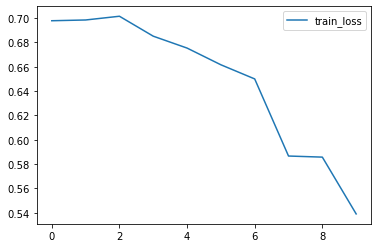

In [7]:
plt.plot(history.history['loss'], label="train_loss")

plt.legend()

In [8]:
test_files = os.listdir('images')[22:38]

In [9]:
test_X = []
for file in test_files:
    image = PIL.Image.open('images/' + file)
    image = image.resize((28, 28))
    test_X.append(np.array(image) / 255.0)
test_X = np.array(test_X)

In [10]:
pred_test_y = model.predict(test_X)

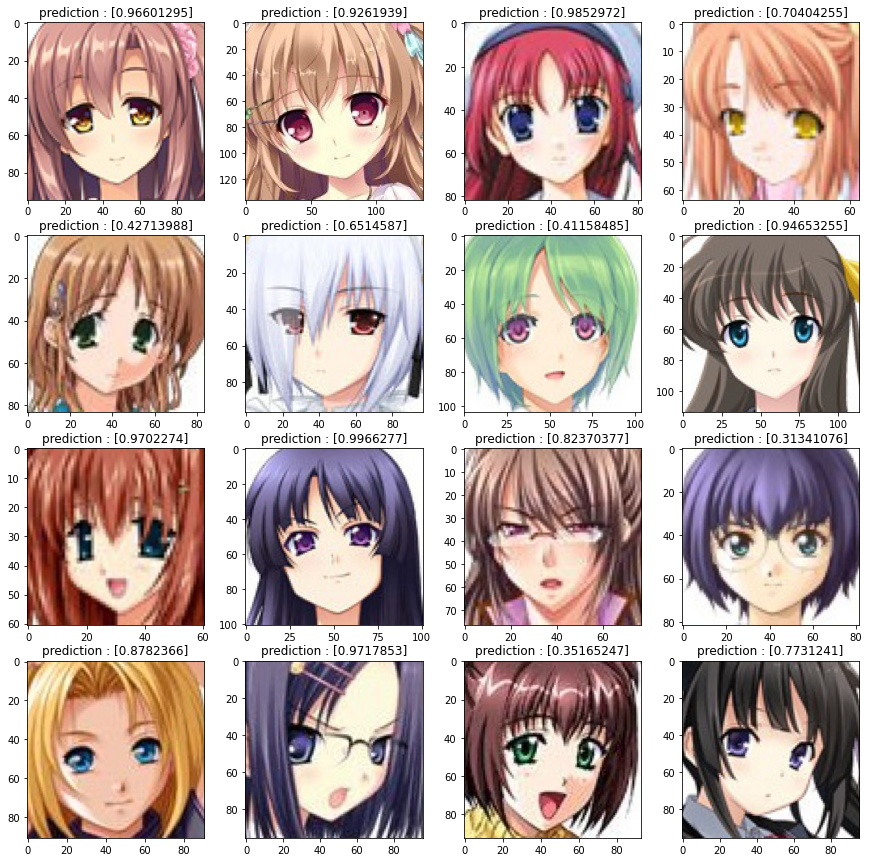

In [11]:
fig, axs = plt.subplots(4, 4, figsize=(15,15))

for i in range(0, 16):
    axs[i // 4][i % 4].imshow(PIL.Image.open('images/' + test_files[i]))
    axs[i // 4][i % 4].set_title("prediction : {}".format(pred_test_y[i]))

In [12]:
new_model = tf.keras.Sequential()
new_model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                 input_shape=[28, 28, 3]))
new_model.add(layers.LeakyReLU())
new_model.add(layers.Dropout(0.3))

new_model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
new_model.add(layers.LeakyReLU())
new_model.add(layers.Dropout(0.3))

new_model.add(layers.Flatten())

In [13]:
generator = models.Sequential()

generator.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
generator.add(layers.BatchNormalization())
generator.add(layers.LeakyReLU())

generator.add(layers.Reshape((7, 7, 256)))
assert generator.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

generator.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
assert generator.output_shape == (None, 7, 7, 128)
generator.add(layers.BatchNormalization())
generator.add(layers.LeakyReLU())

generator.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
assert generator.output_shape == (None, 14, 14, 64)
generator.add(layers.BatchNormalization())
generator.add(layers.LeakyReLU())

generator.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
assert generator.output_shape == (None, 28, 28, 3)

In [14]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [15]:
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=new_model)

status = checkpoint.restore(tf.train.latest_checkpoint('./training_checkpoints'))

In [16]:
new_model.add(layers.Dense(128, activation='relu'))
new_model.add(layers.Dense(64, activation='relu'))
new_model.add(layers.Dense(32, activation='relu'))
new_model.add(layers.Dense(16, activation='relu'))
new_model.add(layers.Dense(8, activation='relu'))
new_model.add(layers.Dense(1, activation='sigmoid'))

In [17]:
new_model.layers

In [18]:
for i in range(0, len(new_model.layers) - 7):
    new_model.layers[i].trainable=False

In [19]:
for i in range(0, len(new_model.layers)):
    print(str(new_model.layers[i]) + str(new_model.layers[i].trainable))

<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc8414d92d0>False
<tensorflow.python.keras.layers.advanced_activations.LeakyReLU object at 0x7fc856e93cd0>False
<tensorflow.python.keras.layers.core.Dropout object at 0x7fc8414d9c90>False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc8414d2a10>False
<tensorflow.python.keras.layers.advanced_activations.LeakyReLU object at 0x7fc8414d9e10>False
<tensorflow.python.keras.layers.core.Dropout object at 0x7fc8579ec4d0>False
<tensorflow.python.keras.layers.core.Flatten object at 0x7fc8579fa790>True
<tensorflow.python.keras.layers.core.Dense object at 0x7fc830d1ec90>True
<tensorflow.python.keras.layers.core.Dense object at 0x7fc830d1efd0>True
<tensorflow.python.keras.layers.core.Dense object at 0x7fc841537890>True
<tensorflow.python.keras.layers.core.Dense object at 0x7fc830d2bdd0>True
<tensorflow.python.keras.layers.core.Dense object at 0x7fc830d2b910>True
<tensorflow.python.keras.layers.core.Dense object at

In [20]:
new_model.compile(optimizer='Adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

history = new_model.fit(X, y, epochs=10)

Train on 200 samples
Epoch 1/10
200/200 [==============================] - 1s 5ms/sample - loss: 0.6465 - accuracy: 0.6200
Epoch 2/10
200/200 [==============================] - 0s 1ms/sample - loss: 0.5096 - accuracy: 0.7550
Epoch 3/10
200/200 [==============================] - 0s 1ms/sample - loss: 0.4719 - accuracy: 0.8050
Epoch 4/10
200/200 [==============================] - 0s 1ms/sample - loss: 0.4114 - accuracy: 0.8350
Epoch 5/10
200/200 [==============================] - 0s 1ms/sample - loss: 0.3737 - accuracy: 0.8550
Epoch 6/10
200/200 [==============================] - 0s 1ms/sample - loss: 0.3538 - accuracy: 0.8300
Epoch 7/10
200/200 [==============================] - 0s 1ms/sample - loss: 0.2904 - accuracy: 0.8800
Epoch 8/10
200/200 [==============================] - 0s 1ms/sample - loss: 0.2859 - accuracy: 0.8750
Epoch 9/10
200/200 [==============================] - 0s 1ms/sample - loss: 0.2074 - accuracy: 0.9350
Epoch 10/10
200/200 [==============================] - 0s 1ms

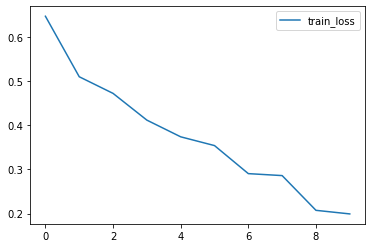

In [21]:
plt.plot(history.history['loss'], label="train_loss")

plt.legend()

In [22]:
pred_test_y = new_model.predict(test_X)

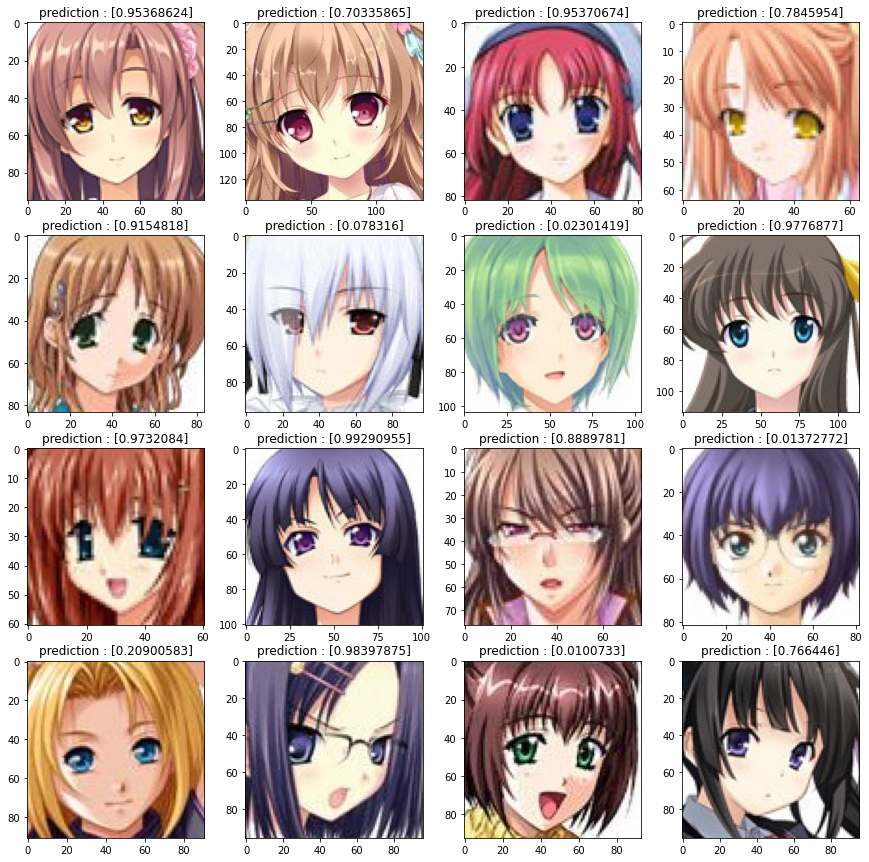

In [23]:
fig, axs = plt.subplots(4, 4, figsize=(15,15))

for i in range(0, 16):
    axs[i // 4][i % 4].imshow(PIL.Image.open('images/' + test_files[i]))
    axs[i // 4][i % 4].set_title("prediction : {}".format(pred_test_y[i]))